## **客户流失预测+聚类分析**

    背景：
    网络视频商家之间存在着巨大的竞争，如果商家想增加收入，他们需要更多的订阅者，但保持现有客户比拥有新客户更重要，所以商家想知道哪些客户可能会取消服务，即客户流失。
    如果知道谁会流失，也许商家可以通过促销来抓住他们。

    内容：
    该数据集收集了使用视频服务的客户相关数据，并在客户流失与否时进行标记。
    基于该数据集，本项目将会创建一个KNN分类模型来预测客户是否流失，并且对所有标记为流失的客户进行KMeans聚类分析，结合pyecharts进行可视化，最终提出面向不同类型流失客户的策略建议。

    步骤：
    1、了解数据集
    2、了解特征情况
    3、KNN建模预测客户是否会流失
    4、根据已有特征 对比流失客户和不流失客户之间的差异
    5、基于KMeans建模 对流失客户进行聚类分析 对不同类别的流失客户提出针对性解决策略

    数据来源：
    https://www.kaggle.com/mehmetsabrikunt/internet-service-churn?select=internet_service_churn.csv


初始化：导入相关包+数据集

In [36]:
#数据处理
import numpy as np
import pandas as pd

#画图
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns 
plt.rcParams['font.sans-serif']=['Heiti TC'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
import warnings
warnings.filterwarnings("ignore")
# pyecharts
from pyecharts import options as opts
from pyecharts.charts import *

import itertools
from itertools import chain

# 建模
from sklearn.preprocessing import  LabelEncoder,scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import  train_test_split
from sklearn.metrics import r2_score,mean_squared_error,accuracy_score,mean_absolute_error,mean_absolute_percentage_error

# 设置Jupyter Notebook在运行时显示所有的输出结果，而不仅仅是最后一个结果
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



In [37]:
path = "/Users/zhangsiyu/Desktop/python练习/项目/Internet provider customer churn/internet_service_churn.csv"
data = pd.read_csv(path)

### **一、了解数据集**
    （1）数据集预览 查看行数、列数、缺失值、数据类型基本信息
    （2）缺失值填充、重复值剔除
    （3）重命名列名


In [38]:
# 数据集一共72274行 11列 均为数值型
data.shape
data.head()
data.info()

(72274, 11)

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,15,1,0,11.95,25,0.14,0,8.4,2.3,0,0
1,18,0,0,8.22,0,NaN,0,0.0,0.0,0,1
2,23,1,0,8.91,16,0.00,0,13.7,0.9,0,1
3,27,0,0,6.87,21,NaN,1,0.0,0.0,0,1
4,34,0,0,6.39,0,NaN,0,0.0,0.0,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72274 entries, 0 to 72273
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           72274 non-null  int64  
 1   is_tv_subscriber             72274 non-null  int64  
 2   is_movie_package_subscriber  72274 non-null  int64  
 3   subscription_age             72274 non-null  float64
 4   bill_avg                     72274 non-null  int64  
 5   reamining_contract           50702 non-null  float64
 6   service_failure_count        72274 non-null  int64  
 7   download_avg                 71893 non-null  float64
 8   upload_avg                   71893 non-null  float64
 9   download_over_limit          72274 non-null  int64  
 10  churn                        72274 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 6.1 MB


In [39]:
# reamining_contract 21572个缺失值
# download_avg upload_avg 381个缺失值
data.isnull().sum()
data.nunique() # 查看特征独特值数量
data.skew().sort_values(ascending=False) # 查看特征偏态分布

id                                 0
is_tv_subscriber                   0
is_movie_package_subscriber        0
subscription_age                   0
bill_avg                           0
reamining_contract             21572
service_failure_count              0
download_avg                     381
upload_avg                       381
download_over_limit                0
churn                              0
dtype: int64

id                             72274
is_tv_subscriber                   2
is_movie_package_subscriber        2
subscription_age                1110
bill_avg                         179
reamining_contract               247
service_failure_count             19
download_avg                    2856
upload_avg                       802
download_over_limit                8
churn                              2
dtype: int64

upload_avg                     14.620348
download_avg                   14.580942
bill_avg                        7.358908
service_failure_count           5.592502
download_over_limit             5.269831
subscription_age                1.295647
is_movie_package_subscriber     0.700945
reamining_contract              0.401173
id                             -0.004863
churn                          -0.217850
is_tv_subscriber               -1.624711
dtype: float64

In [40]:
# 处理缺失值
# 根据实际含义 合同剩余年限空值代表没有合同 填充为0
# 查看数值分布 平均下载量和上传量超过10000条都是0 也填充为0
data = data.fillna(0)
# 删除重复值
data = data.drop_duplicates()

In [6]:
# 重命名列名 其中"平均账单金额","投诉次数","平均下载量","平均上传量","限制次数"特征的时间维度均为过去3个月
data.columns = ["客户ID","If_电视","If_电影套餐","客户年限","平均账单金额","合同剩余年限","投诉次数","平均下载量","平均上传量","限制次数","是否流失"]

### **二、了解特征变量**
    （1）结合实际含义，区分分类变量和数值型变量
    （2）查看分类变量独特值及其分布
    （3）查看数值型变量数据分布
    （4）查看特征的描述性统计信息
    （5）查看特征变量之间关系、相关系数

In [7]:
# 区分分类变量和数值变量
col_cate = ["If_电视","If_电影套餐","投诉次数","限制次数","是否流失"]
col_num = ["客户年限","平均账单金额","合同剩余年限","平均下载量","平均上传量"]

If_电视 特征的各数据出现次数：
 1    58922
0    13352
Name: If_电视, dtype: int64


<Figure size 720x288 with 0 Axes>

<AxesSubplot:xlabel='If_电视', ylabel='count'>

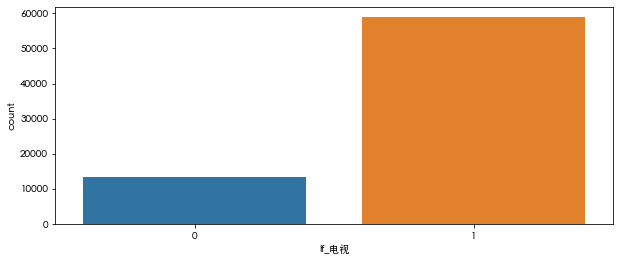

------------------------------------------------------------ 

If_电影套餐 特征的各数据出现次数：
 0    48089
1    24185
Name: If_电影套餐, dtype: int64


<Figure size 720x288 with 0 Axes>

<AxesSubplot:xlabel='If_电影套餐', ylabel='count'>

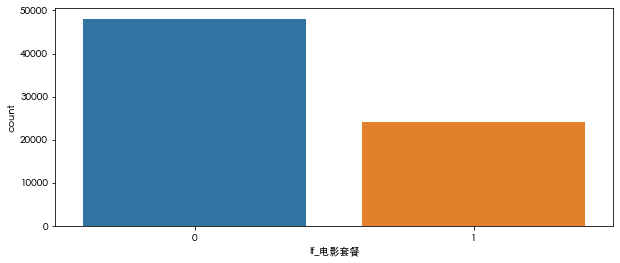

------------------------------------------------------------ 

投诉次数 特征的各数据出现次数：
 0     60407
1      7665
2      2453
3       901
4       395
5       201
6        97
7        58
8        37
9        17
10       15
11        6
12        6
13        5
14        4
16        3
15        2
18        1
19        1
Name: 投诉次数, dtype: int64


<Figure size 720x288 with 0 Axes>

<AxesSubplot:xlabel='投诉次数', ylabel='count'>

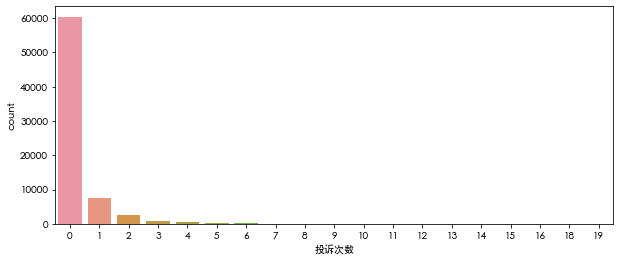

------------------------------------------------------------ 

限制次数 特征的各数据出现次数：
 0    68373
1      766
6      688
2      560
7      504
3      498
4      456
5      429
Name: 限制次数, dtype: int64


<Figure size 720x288 with 0 Axes>

<AxesSubplot:xlabel='限制次数', ylabel='count'>

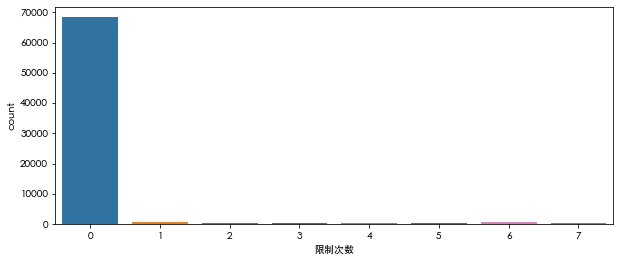

------------------------------------------------------------ 

是否流失 特征的各数据出现次数：
 1    40050
0    32224
Name: 是否流失, dtype: int64


<Figure size 720x288 with 0 Axes>

<AxesSubplot:xlabel='是否流失', ylabel='count'>

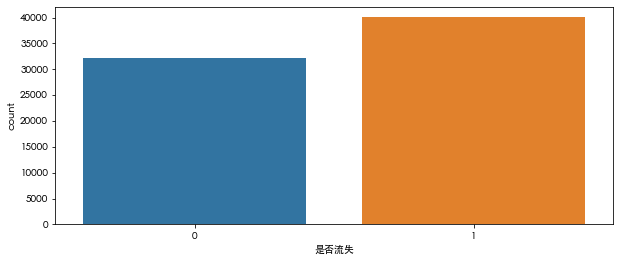

------------------------------------------------------------ 



In [8]:
# 查看分类特征col_cate的数据分布
for i in col_cate:
    print(i,"特征的各数据出现次数：\n",data[i].value_counts()) # “\n”代表换行 value_counts()可设置参数ascending=True|False对结果升序|降序
    plt.figure(figsize=(10,4)) # 新增一个画布
    sns.countplot(x=i,data=data) # 对该变量绘制直方图
    plt.show()
    print("--"*30,"\n") #分割线

array([[<AxesSubplot:title={'center':'客户年限'}>,
        <AxesSubplot:title={'center':'平均账单金额'}>],
       [<AxesSubplot:title={'center':'合同剩余年限'}>,
        <AxesSubplot:title={'center':'平均下载量'}>],
       [<AxesSubplot:title={'center':'平均上传量'}>, <AxesSubplot:>]],
      dtype=object)

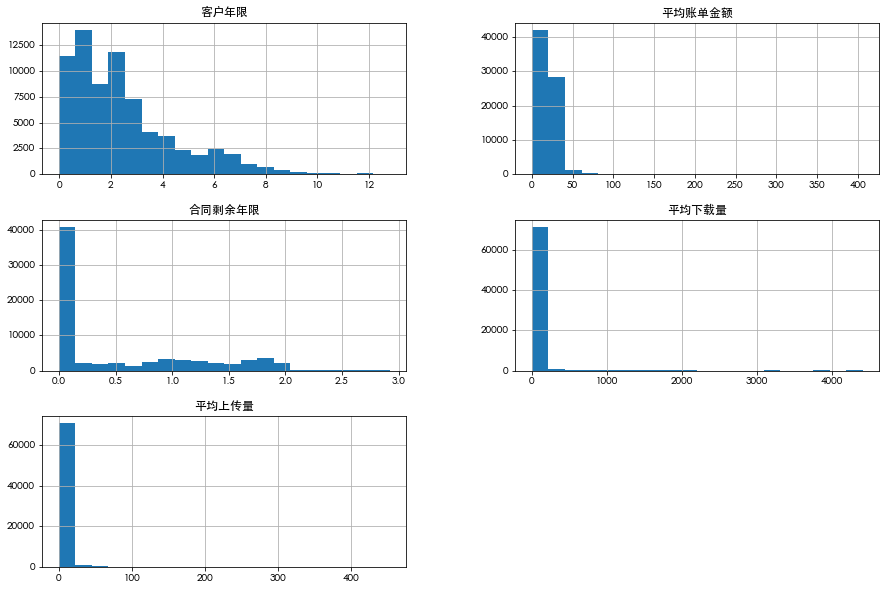

In [9]:
# 查看数值型特征的数据分布
data[col_num].hist(bins=20,figsize=(15,10))

In [10]:
# 查看描述性统计信息
data.describe()

,客户ID,If_电视,If_电影套餐,客户年限,平均账单金额,合同剩余年限,投诉次数,平均下载量,平均上传量,限制次数,是否流失
count,7.227400e+04,72274.000000,72274.000000,72274.000000,72274.000000,72274.000000,72274.000000,72274.000000,72274.000000,72274.000000,72274.000000
mean,8.463182e+05,0.815259,0.334629,2.450051,18.942483,0.502319,0.274234,43.459595,4.169977,0.207613,0.554141
std,4.891022e+05,0.388090,0.471864,2.034990,13.215386,0.669524,0.816621,63.317706,9.797685,0.997123,0.497064
min,1.500000e+01,0.000000,0.000000,-0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.222165e+05,1.000000,0.000000,0.930000,13.000000,0.000000,0.000000,6.400000,0.500000,0.000000,0.000000
50%,8.477840e+05,1.000000,0.000000,1.980000,19.000000,0.000000,0.000000,27.500000,2.100000,0.000000,1.000000
75%,1.269562e+06,1.000000,1.000000,3.300000,22.000000,1.040000,0.000000,60.200000,4.800000,0.000000,1.000000
max,1.689744e+06,1.000000,1.000000,12.800000,406.000000,2.920000,19.000000,4415.200000,453.300000,7.000000,1.000000


In [11]:
# 查看变量之间关系
# sns.pairplot(data,hue="是否流失")
# plt.show() 

<Figure size 1440x576 with 0 Axes>

<AxesSubplot:>

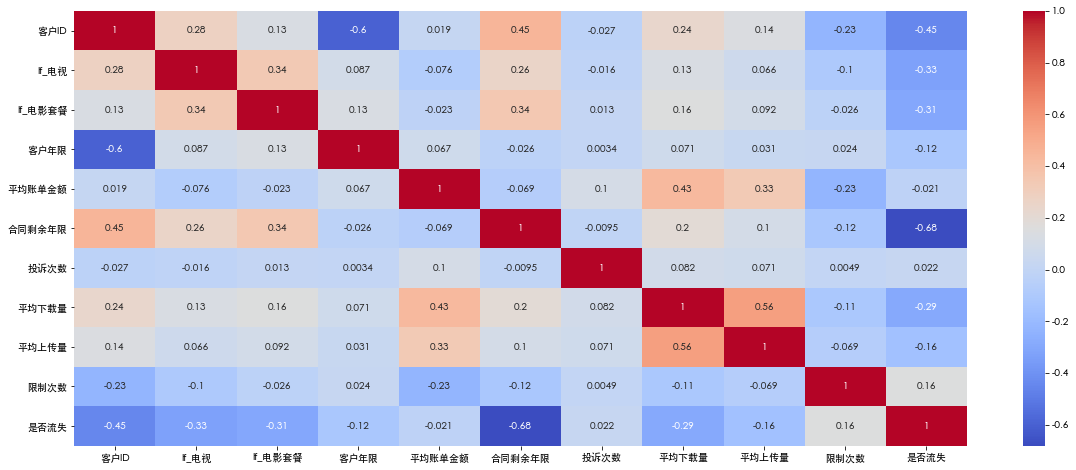

In [12]:
# 查看特征之间的相关性系数
# 从相关性系数中可以初步看出 订购套餐越多、合同剩余年限越多、上传下载活动越活跃，流失的概率越低； 限制次数越多、投诉越多，流失概率越大，符合我们的常识认知。
corr = data.corr()
plt.figure(figsize=(20,8))
sns.heatmap(data=corr,xticklabels=corr.columns,yticklabels=corr.columns,annot=True,cmap="coolwarm")

### **三、KNN建模 预测客户是否流失**
    （1）对数据进行缩放
    （2）划分数据集
    （3）KNN模型拟合+预测
    （4）预测结果评估
    

提取自变量和因变量，标准化缩放处理、

In [13]:
X = data[['If_电视', 'If_电影套餐', '客户年限', '平均账单金额', '合同剩余年限', '投诉次数', '平均下载量','平均上传量', '限制次数']]
y = data[['是否流失']]


In [14]:
from sklearn.preprocessing import scale
X_scale = scale(X)
y = y.values

划分数据集，测试集数量30%

In [15]:
X_train,X_test,y_train,y_test = train_test_split(X_scale,y,test_size=0.3,random_state=888)

导入KNN模型

In [16]:
from sklearn.neighbors import KNeighborsClassifier
model_KNN = KNeighborsClassifier() # 实例化
model_KNN.fit(X_train,y_train) # 拟合
pre_KNN = model_KNN.predict(X_test) # 预测测试集结果


KNeighborsClassifier()

,是否流失预测结果
0,0
1,1
2,1
3,0
4,1


,人数
是否流失预测结果,
1,11901
0,9782


array([[<AxesSubplot:title={'center':'是否流失预测结果'}>]], dtype=object)

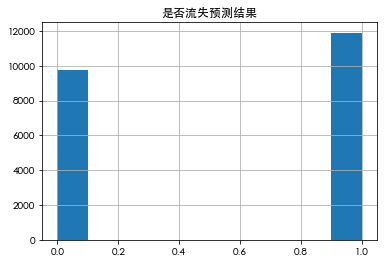

In [17]:
pre_KNN=pd.DataFrame(pre_KNN,columns=["是否流失预测结果"]) # 转化为DataFrame形式
pre_KNN.head() # 预览前五行
pd.DataFrame(pre_KNN.value_counts(),columns=["人数"]) # 预测结果数据分布
pre_KNN.hist() # 绘制直方图查看分布


对预测结果进行评估 准确度约为91%

In [18]:
from sklearn.metrics import accuracy_score #评估预测结果
print(accuracy_score(y_test,pre_KNN)) # 准确率

0.9060093160540516


### **四、流失客户 VS 非流失客户**
    （1）透视表功能 获得所需要的数据 
    （2）整个数据集中，标记为流失的客户有40050人，非流失客户有32224人
    （3）pyecharts对特征进行可视化

In [19]:
# 第一步 透视表功能 获得所需要的数据 
con = pd.concat([pd.pivot_table(data,index=["是否流失"],values=["客户ID"],aggfunc="count"),pd.pivot_table(data,index=["是否流失"],aggfunc="mean").drop(["客户ID"],axis=1)],axis=1)
con.rename(columns={"客户ID":"人数"}) # 选择性更改列名


,人数,If_电影套餐,If_电视,合同剩余年限,客户年限,平均上传量,平均下载量,平均账单金额,投诉次数,限制次数
是否流失,,,,,,,,,,
0,32224,0.496214,0.956989,1.011077,2.727828,5.912817,64.117565,19.252731,0.254593,0.031622
1,40050,0.204619,0.701223,0.092976,2.226554,2.767698,26.838312,18.692859,0.290037,0.349213


In [20]:
# 提取数据
x_bar =['If_电影套餐', 'If_电视', '合同剩余年限', '客户年限', '平均上传量', '平均下载量','平均账单金额', '投诉次数', '限制次数']
for i in x_bar:
    con[i] = con[i].apply(lambda x :round(x,2))
y1_data_bar = con.iloc[0,1:].tolist()
y2_data_bar = con.iloc[1,1:].tolist()

# 绘制
bar = (Bar(init_opts=opts.InitOpts(width= "600px",height="400px",theme="dark",bg_color="rgba(51,51,51,0.8)"))
            .add_xaxis(x_bar)
            .add_yaxis("非流失",y1_data_bar,itemstyle_opts=opts.ItemStyleOpts(color="#339999"))
            .add_yaxis("流失",y2_data_bar,itemstyle_opts=opts.ItemStyleOpts(color="#FF6666"))
            
            .set_global_opts(
                            datazoom_opts=opts.DataZoomOpts(range_start=50,range_end=80,orient="horizontal")
                            ,title_opts=opts.TitleOpts(title="流失&非流失客户",subtitle=" ",pos_left="center",pos_top="4%"
                                                        ,title_textstyle_opts = opts.TextStyleOpts(color = "white",font_family="Macrosoft YaHei")
                                                        ,subtitle_textstyle_opts = opts.TextStyleOpts(color="white",font_family="Macrosoft YaHei")
                                                        )

                            ,legend_opts = opts.LegendOpts(is_show = True,pos_right = "10%",pos_top="15%",orient="vertical",legend_icon="circle"
                                                            ,textstyle_opts=opts.TextStyleOpts(font_family="Macrosoft YaHei")
                                                            
                                                            )
                            ,yaxis_opts=opts.AxisOpts(is_show=False)
                            #,xaxis_opts=opts.AxisOpts(is_show=True,name_rotate = 30,name_textstyle_opts=opts.TextStyleOpts(color="yellow",font_family="Macrosoft YaHei"))                           
                            )
            .set_series_opts(
                            label_opts=opts.LabelOpts(color="auto")

                            )


           )

bar.render_notebook()


### **五、KMeans聚类分析 **
    （1）提取全部流失客户群体churn（40050条）
    （2）结合特征实际含义，构造客户流失模型（CMASL）
    （3）选择聚类簇K值 拟合KMeans模型
    （4）将流失客户划分为K类群体 对其CMASL的各个维度进行可视化展示和分析
    （5）针对不同流失群体进行策略建议


In [21]:
# 第一步 先把流失客户群体的数据集挑出来
churn = data[data["是否流失"]==1]
churn = churn.reset_index(drop=True)
churn.head()


,客户ID,If_电视,If_电影套餐,客户年限,平均账单金额,合同剩余年限,投诉次数,平均下载量,平均上传量,限制次数,是否流失
0,18,0,0,8.22,0,0.0,0,0.0,0.0,0,1
1,23,1,0,8.91,16,0.0,0,13.7,0.9,0,1
2,27,0,0,6.87,21,0.0,1,0.0,0.0,0,1
3,34,0,0,6.39,0,0.0,0,0.0,0.0,0,1
4,71,0,0,8.96,18,0.0,0,21.3,2.0,0,1


In [22]:
churn.describe()

,客户ID,If_电视,If_电影套餐,客户年限,平均账单金额,合同剩余年限,投诉次数,平均下载量,平均上传量,限制次数,是否流失
count,4.005000e+04,40050.000000,40050.000000,40050.000000,40050.000000,40050.000000,40050.000000,40050.000000,40050.000000,40050.000000,40050.0
mean,6.483943e+05,0.701223,0.204619,2.226554,18.692859,0.092976,0.290037,26.838312,2.767698,0.349213,1.0
std,4.322926e+05,0.457727,0.403428,1.709438,13.073794,0.339111,0.865134,46.137197,7.932245,1.290545,0.0
min,1.800000e+01,0.000000,0.000000,-0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,2.863745e+05,0.000000,0.000000,0.980000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,5.907300e+05,1.000000,0.000000,1.970000,20.000000,0.000000,0.000000,11.900000,0.900000,0.000000,1.0
75%,9.498655e+05,1.000000,0.000000,2.940000,23.000000,0.000000,0.000000,36.700000,2.900000,0.000000,1.0
max,1.689744e+06,1.000000,1.000000,12.800000,278.000000,2.310000,19.000000,1706.200000,327.200000,7.000000,1.0


计算公式： 

    C(合同状态) = 合同剩余年限
    M(消费金额) = 平均下载量 + 平均上传量 + 平均账单金额
    A(活跃度) = If_电视 + If_电影套餐
    S(满意度) = 投诉次数 + 限制次数
    L(服务时长) = 客户年限

In [23]:
cal = {
    "C":churn["合同剩余年限"]
    ,"M":churn["平均下载量"]+churn["平均上传量"]+churn["平均账单金额"]
    ,"A":churn["If_电视"]+churn["If_电影套餐"]
    ,"S":churn["投诉次数"]+churn["限制次数"]
    ,"L":churn["客户年限"]   
}

data_class = pd.DataFrame(data=cal,columns=["C","M","A","S","L"])
data_class

,C,M,A,S,L
0,0.00,0.0,0,0,8.22
1,0.00,30.6,1,0,8.91
2,0.00,21.0,0,1,6.87
3,0.00,0.0,0,0,6.39
4,0.00,41.3,0,0,8.96
...,...,...,...,...,...
40045,1.25,0.0,2,0,0.09
40046,1.63,1.8,1,0,0.06
40047,2.19,1.7,1,0,0.02
40048,0.72,0.0,0,0,0.01


In [24]:
# 标准化处理
data_class = pd.DataFrame(scale(data_class),columns=["C","M","A","S","L"])
data_class_ID = pd.concat([churn[["客户ID"]],data_class],axis=1)
data_class

,C,M,A,S,L
0,-0.274177,-0.835332,-1.288250,-0.411060,3.506135
1,-0.274177,-0.306103,0.133906,-0.411060,3.909781
2,-0.274177,-0.472136,-1.288250,0.231974,2.716392
3,-0.274177,-0.835332,-1.288250,-0.411060,2.435594
4,-0.274177,-0.121046,-1.288250,-0.411060,3.939031
...,...,...,...,...,...
40045,3.411973,-0.835332,1.556063,-0.411060,-1.249873
40046,4.532562,-0.804201,0.133906,-0.411060,-1.267422
40047,6.183957,-0.805931,0.133906,-0.411060,-1.290822
40048,1.849045,-0.835332,-1.288250,-0.411060,-1.296672


选择聚类簇

In [25]:
# 从sklearn导入聚类算法函数
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [26]:
'''
score = []
inertia = []
nums=range(2,10)

# 遍历多个可能的候选簇数量
for n_clusters in range(2,10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=888)
    kmeans.fit(data_class)
    inertia.append(kmeans.inertia_)#衡量模型性能
    score.append(silhouette_score(data_class, kmeans.labels_,sample_size=128, metric='euclidean')) #衡量聚类算法的指标

plt.figure(figsize=(10, 6))
# 使用ggplot的绘图风格
plt.style.use('seaborn-darkgrid')
plt.subplot(121)
plt.plot(nums,score)
plt.grid(linestyle=':')
plt.xlabel('K')
plt.ylabel('Score')
plt.title('Performance of K-means')

plt.subplot(122)
plt.plot(nums,inertia)
plt.grid(linestyle=':')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.title('Inertia of K-means')
plt.show()
'''

"\nscore = []\ninertia = []\nnums=range(2,10)\n\n# 遍历多个可能的候选簇数量\nfor n_clusters in range(2,10):\n    kmeans = KMeans(n_clusters=n_clusters, random_state=888)\n    kmeans.fit(data_class)\n    inertia.append(kmeans.inertia_)#衡量模型性能\n    score.append(silhouette_score(data_class, kmeans.labels_,sample_size=128, metric='euclidean')) #衡量聚类算法的指标\n\nplt.figure(figsize=(10, 6))\n# 使用ggplot的绘图风格\nplt.style.use('seaborn-darkgrid')\nplt.subplot(121)\nplt.plot(nums,score)\nplt.grid(linestyle=':')\nplt.xlabel('K')\nplt.ylabel('Score')\nplt.title('Performance of K-means')\n\nplt.subplot(122)\nplt.plot(nums,inertia)\nplt.grid(linestyle=':')\nplt.xlabel('K')\nplt.ylabel('Inertia')\nplt.title('Inertia of K-means')\nplt.show()\n"

In [27]:
# 最好的簇数量为6
k = 6

model_KM = KMeans(n_clusters=k)
model_KM.fit(data_class) # 拟合KNN模型

print(model_KM.labels_) # 打印聚类标签

KMeans(n_clusters=6)

[2 2 2 ... 0 5 0]


In [28]:
centers = pd.DataFrame(model_KM.cluster_centers_,columns=data_class.columns)# 查看聚类中心
labels = pd.DataFrame(model_KM.labels_,columns=["分组标签"]) # 查看聚类标签


In [29]:
# 查看各聚类分组的人数
labels_count = pd.DataFrame(labels.value_counts(),columns=["人数"]).sort_index()
labels_count = labels_count.reset_index()
# 查看6个分组的人数+五大维度信息
final = pd.concat([labels_count,centers],axis=1)
final["分组标签"] = ["class_1","class_2","class_3","class_4","class_5","class-6"]
final

,分组标签,人数,C,M,A,S,L
0,class_1,2331,3.752926,0.235576,0.507901,-0.153957,-0.280789
1,class_2,18677,-0.237370,-0.091902,0.479981,-0.257199,-0.376720
2,class_3,5668,-0.218959,0.077475,0.318000,-0.228388,1.778628
3,class_4,2679,-0.203795,-0.556109,-0.038090,3.214076,0.172901
4,class_5,1366,-0.107721,3.350818,0.126597,-0.069714,-0.066139
5,class-6,9329,-0.255136,-0.251560,-1.288250,-0.220582,-0.298431


玫瑰图 - 可视化6大分组人数

In [35]:
# 提取数据
pie_data = final.iloc[:,:2]
pie_data = pie_data.sort_values("人数",ascending=False)

x_pie = pie_data["分组标签"].values.tolist()
y_pie = pie_data["人数"].values.tolist()

# 绘制
pie = (Pie(init_opts=opts.InitOpts(width="500px",height="600px",theme="roma",bg_color="rgba(32,32,32,1)"))
            .add("流失客户聚类",[list(z) for z in zip(x_pie,y_pie)]
                    #,rosetype="area"
                    ,radius=["20%","80%"]
                    ,center=["50%","55%"]
                )

            .set_global_opts(title_opts=opts.TitleOpts(title="流失客户各组人数",pos_left="center",pos_top="5%"
                                                        ,title_textstyle_opts=opts.TextStyleOpts(color = "white",font_family="Macosoft YaHei",font_size=20)
                                                        
                                                        )
                                ,legend_opts=opts.LegendOpts(orient="vertical",type_="scroll",pos_right="5%",pos_top="5%"
                                                              ,legend_icon="triangle",item_width=12,item_height=12
                                                              ,textstyle_opts=opts.TextStyleOpts(color="white")
                                                              
                                                              )

                              )
            .set_series_opts(label_opts=opts.LabelOpts(position = "inside",formatter="{b}:{c}")
                             )
        )

pie.render_notebook()

热力图 - 可视化各分组特征

<Figure size 1080x432 with 0 Axes>

<AxesSubplot:>

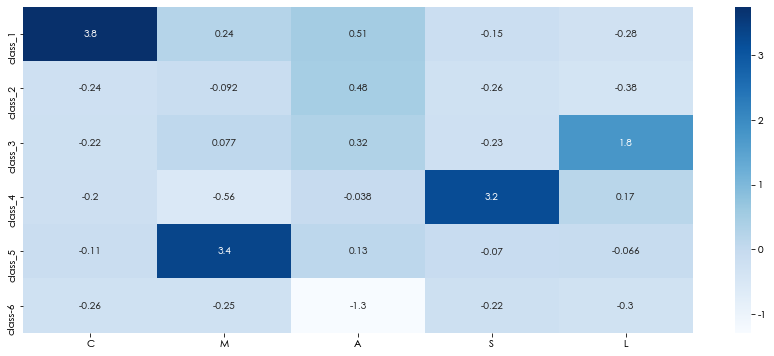

In [31]:
plt.figure(figsize=(15,6))
sns.heatmap(data=centers,xticklabels=centers.columns,yticklabels = final["分组标签"],annot=True,cmap="Blues")

雷达图 - 可视化聚类分组特征

In [32]:
for i in ["C","M","A","S","L"]:
    final[i] = final[i].apply(lambda x : round(x,2))

# 提取数据
class_1 = final.iloc[[0],2:].values.tolist()
class_2 = final.iloc[[1],2:].values.tolist()
class_3 = final.iloc[[2],2:].values.tolist()
class_4 = final.iloc[[3],2:].values.tolist()
class_5 = final.iloc[[4],2:].values.tolist()
class_6 = final.iloc[[5],2:].values.tolist()




In [33]:
# 绘制
max = centers.values.max()
min = centers.values.min()

#背景分割线颜色
split_line_style = {'color': [
                    'rgba(255, 255, 240, 0.1)', 'rgba(255, 255, 240, 0.2)',
                    'rgba(255, 255, 240, 0.3)', 'rgba(255, 255, 240, 0.3)',
                    'rgba(255, 255, 240, 0.4)', 'rgba(255, 255, 240, 0.4)'
                    ][::-1]
    
                    }

radar = (Radar(init_opts=opts.InitOpts(width="800px",height="800px",theme="macarons",bg_color="rgba(32,32,32,1)"))
                .add_schema(shape="circle"
                    ,splitline_opt = opts.SplitLineOpts(is_show=True,linestyle_opts=split_line_style)
                    ,schema = [opts.RadarIndicatorItem(name="C",min_=min-0.1,max_=max+0.1)
                              ,opts.RadarIndicatorItem(name="M",min_=min-0.1,max_=max+0.1)
                              ,opts.RadarIndicatorItem(name="A",min_=min-0.1,max_=max+0.1)
                              ,opts.RadarIndicatorItem(name="S",min_=min-0.1,max_=max+0.1)
                              ,opts.RadarIndicatorItem(name="L",min_=min-0.1,max_=max+0.1)
                              
                             ]
                       
                          
                          
                          
                          
                           )
                .add("class_1",class_1
                    ,linestyle_opts=opts.LineStyleOpts(color="#003399",width=1,opacity=0.8)
                    ,areastyle_opts=opts.AreaStyleOpts(color="#003399",opacity=0.05)
                    ,label_opts = opts.LabelOpts(is_show=False)
                    )
                .add("class_2",class_2
                    ,linestyle_opts=opts.LineStyleOpts(color="#99CCCC",width=1,opacity=0.8)
                    ,areastyle_opts=opts.AreaStyleOpts(color="#99CCCC",opacity=0.05)
                    ,label_opts = opts.LabelOpts(is_show=False)
                    )
                .add("class_3",class_3
                    ,linestyle_opts=opts.LineStyleOpts(color="#006699",width=1,opacity=0.8)
                    ,areastyle_opts=opts.AreaStyleOpts(color="#006699",opacity=0.05)
                    ,label_opts = opts.LabelOpts(is_show=False)
                
                    )
                .add("class_4",class_4
                    ,linestyle_opts=opts.LineStyleOpts(color="#66CC99",width=1,opacity=0.8)
                    ,areastyle_opts=opts.AreaStyleOpts(color="#66CC99",opacity=0.05)
                    ,label_opts = opts.LabelOpts(is_show=False)
                
                
                
                    )
                .add("class_5",class_5
                    ,linestyle_opts=opts.LineStyleOpts(color="#FFCCCC",width=1,opacity=0.8)
                    ,areastyle_opts=opts.AreaStyleOpts(color="#FFCCCC",opacity=0.05)
                    ,label_opts = opts.LabelOpts(is_show=False)
                
                
                    )
                .add("class_6",class_6
                    ,linestyle_opts=opts.LineStyleOpts(color="#339999",width=1,opacity=0.8)
                    ,areastyle_opts=opts.AreaStyleOpts(color="#339999",opacity=0.1)
                    ,label_opts = opts.LabelOpts(is_show=False)
                
                
                    )
             
                
                
                    
                .set_global_opts(
                                title_opts=opts.TitleOpts(title="流失客户聚类分析雷达图",subtitle=" —— 基于KMeans",pos_left="center",pos_top="2%"
                                                        ,title_textstyle_opts = opts.TextStyleOpts(color = "white",font_family="Macrosoft YaHei")
                                                        ,subtitle_textstyle_opts = opts.TextStyleOpts(color="white",font_family="Macrosoft YaHei")
                                                        )
                                ,legend_opts = opts.LegendOpts(is_show = True,pos_right = "5%",pos_top="5%",orient="vertical",legend_icon="arrow"
                                                                ,item_width=10,item_height=10,type_="scroll"
                                                                ,textstyle_opts=opts.TextStyleOpts(color="white",font_family="Macrosoft YaHei")
                                                            
                                                            )




                                )




)

radar.render_notebook()

计算公式： 

    C(合同状态) = 合同剩余年限
    M(消费金额) = 平均下载量 + 平均上传量 + 平均账单金额
    A(活跃度) = If_电视 + If_电影套餐
    S(满意度) = 投诉次数 + 限制次数
    L(服务时长) = 客户年限

聚类分析&策略建议：

    （1）class_1:
        · 这类客户人数占比较大，在“A”维度明显短缺
        · 表明这类客户属于没有或很少订阅过电视或者电影套餐服务的群体
        · 建议对这类客户增加订阅服务的次数，或者推送一些订阅服务指南之类的内容，打开他们使用产品的基本操作。
    （2）class_2:
        · 在“L”维度明显很高，其他4个维度表现一般
        · 表明这类流失客户是服务年限较长的老客户
        · 一般来说，丢失一个老客户付出的成本是很高的，建议针对这些老客户做一些抽样回访和调研，或许他们能提供很多用户视角的有效建议
    （3）class_3:
        · 在“S”维度表现突出，在“M”维度明显短缺
        · 表明这类客户属于的满意度较低，且不爱消费的客户
        · 可能这些客户不喜欢这款产品，他们产出的消费价值较低，在流失客户中占比也较低，建议可以战略性放弃。
    （4）class_4:
        · 在“C”维度表现突出，在“S”和“L”维度相对较低
        · 从相关系数上看，订阅合同是避免流失的最重要因素，而这类客户很多都是已经签署了contract的客户，他们的消费水平、活跃度、满意度也比较高，客户年限上表现得较为年轻，表明他们虽然人数不多，但是属于潜力客户。
        · 建议将这类客户标记为“种子用户”，对他们做好重点维护
    （5）class_5:
        · 在“M”维度表现突出
        · 表明这类客户属于具有明显消费能力，平时下载和上传需求较大的客户群体
        · 建议加强对这类客户的推荐系统配置，例如更精准地判断他们的喜好，更高频率地推送相关内容，满足他们的大量需求
    （6）class_6:
        · 各个维度不是特别突出，相对来说“A”维度会较高一些
        · 表明他们订阅了电视或者电影套餐，但是没有表现出其他的特征
        · 这类客户虽然特征不明显，但是占比权重最大，属于自然流失群体。


In [34]:
# 输出所有流失以及流失倾向客户的信息
data_class_ID = pd.concat([labels+1,churn,data_class],axis=1)
data_class_ID

,分组标签,客户ID,If_电视,If_电影套餐,客户年限,平均账单金额,合同剩余年限,投诉次数,平均下载量,平均上传量,限制次数,是否流失,C,M,A,S,L
0,3,18,0,0,8.22,0,0.00,0,0.0,0.0,0,1,-0.274177,-0.835332,-1.288250,-0.411060,3.506135
1,3,23,1,0,8.91,16,0.00,0,13.7,0.9,0,1,-0.274177,-0.306103,0.133906,-0.411060,3.909781
2,3,27,0,0,6.87,21,0.00,1,0.0,0.0,0,1,-0.274177,-0.472136,-1.288250,0.231974,2.716392
3,3,34,0,0,6.39,0,0.00,0,0.0,0.0,0,1,-0.274177,-0.835332,-1.288250,-0.411060,2.435594
4,3,71,0,0,8.96,18,0.00,0,21.3,2.0,0,1,-0.274177,-0.121046,-1.288250,-0.411060,3.939031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40045,1,1689648,1,1,0.09,0,1.25,0,0.0,0.0,0,1,3.411973,-0.835332,1.556063,-0.411060,-1.249873
40046,1,1689676,1,0,0.06,1,1.63,0,0.8,0.0,0,1,4.532562,-0.804201,0.133906,-0.411060,-1.267422
40047,1,1689679,1,0,0.02,0,2.19,0,1.5,0.2,0,1,6.183957,-0.805931,0.133906,-0.411060,-1.290822
40048,6,1689733,0,0,0.01,0,0.72,0,0.0,0.0,0,1,1.849045,-0.835332,-1.288250,-0.411060,-1.296672
